# Meteorological Data Extraction and Preprocessing

This notebook focuses on extracting meteorological data from the [ERA5 dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview), encompassing temperature and precipitation records spanning from 2000 to 2024 on a daily basis. Our objective is to analyse the influence of weather patterns on food security, specifically by assessing key food security indicators: the Food Consumption Score (FCS) and Household Dietary Diversity Score (HDDS).

Utilizing the [ERA5 API](https://cds.climate.copernicus.eu/api-how-to) ,  we retrieve the meteorological data for our two study area, Tanzania and Rwanda in the NetCDF file format (.ncdf). Initial we compute the bounding box of each country to retrieve the weather data of the whole countries then we employ geospatial techniques to integrate the meteorological data with the administrative boundaries of country districts. By employing shapefiles containing the polygons representing each district's boundaries, we perform spatial operations such as clipping to precisely extract the corresponding temperature, precipitation, and other meteorological variables for each district from NetCDF data file. This approach enables us to obtain localized weather data, facilitating a district-level analysis of weather patterns and their impact on food security indicators. 

[ERA5 dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview)

### Import Libraries

In [37]:
#!pip install cdsapi
#!pip install xarray cfgrib
#!pip install eccodes
#!pip install ecmwflibs
#!pip install scipy

In [38]:
import pandas as pd
from pandas import read_csv
import geopandas as gpd
from geopandas import read_file
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import calendar
import cdsapi
import ecmwflibs
import os
from scipy.io import netcdf
from netCDF4 import Dataset
import numpy as np
import cfgrib
import xarray as xr
import rioxarray as rx
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import time

## Helper Functions

This section contains a collection of utility functions designed to streamline and enhance various processes within the notebook. These functions serve as auxiliary tools that encapsulate specific tasks or computations, allowing for cleaner and more modular code organization.It include the functions for changing one file format of data to another, combine data files,batch processing function that allow the processing of many files on a single calls. This description of each function and what they provide is explained in document comments in each function.

In [39]:
def grib_to_dataframe(grib_file):
    
    '''
    Reads a GRIB file and converts its contents into a DataFrame.

    Parameters:
        grib_file (str): Path to the GRIB file.

    Returns:
        pandas.DataFrame: DataFrame containing the data from the GRIB file.
                          Each column represents a variable, and each row represents a time step.
    '''
    try:
        # Open the GRIB file using xarray with the cfgrib engine
        ds=xr.open_dataset(grib_file, engine="cfgrib")

        # Convert the dataset to a pandas DataFrame
        df = ds.to_dataframe()

        return df

    except Exception as e:
        print("An error occurred:", str(e))
        return None

In [40]:
def netcdf_to_dataframe(netcdf_file):
    
    '''
    Reads a netCDF file and converts its contents into a DataFrame.

    Parameters:
        netcdf_file (str): Path to the netCDF file.

    Returns:
        pandas.DataFrame: DataFrame containing the data from the netCDF file.
                          Each column represents a variable, and each row represents a time step.
    '''
    try:
        # Open the netCDF file using xarray
        ds = xr.open_dataset(netcdf_file,engine="netcdf4")

        # Convert the dataset to a pandas DataFrame
        df = ds.to_dataframe()

        return df

    except Exception as e:
        print("An error occurred:", str(e))
        return None


In [41]:
def concatenate_nc_files(input_files, output_filename):
    
    '''
    Concatenates a list of NetCDF files along the time dimension into a single NetCDF file.

    Parameters:
        input_files (list of str): List of paths to input NetCDF files to concatenate.
        output_filename (str): Path to the output concatenated NetCDF file.

    Returns:
        str: Path to the concatenated NetCDF file.
    '''
    try:
        datasets = [xr.open_dataset(file) for file in input_files]
        combined_data = xr.concat(datasets, dim='time')
        combined_data.to_netcdf(output_filename)
        print(f"All files successfully concatenated into {output_filename}.")
        return output_filename
    finally:
        for dataset in datasets:
            dataset.close()

In [42]:
def concatenate_csv_files(input_files, output_file):
    
    '''
    Concatenate multiple CSV files into one and save it as a new CSV file.

    Parameters:
    - input_files: List of input CSV file paths.
    - output_file: Output CSV file path where merged data will be saved.
    
    '''
    # Initialize an empty DataFrame to store merged data
    merged_data = pd.DataFrame()

    # Iterate over each input file
    for file in input_files:
        # Read each CSV file into a DataFrame
        data = read_csv(file)
        # Concatenate data from each file to the merged_data DataFrame
        merged_data = pd.concat([merged_data, data], ignore_index=True)

    # Write the merged data to a new CSV file
    merged_data.to_csv(output_file, index=False)
    print("Merged data saved to:", output_file)


In [77]:
def process_rainfall_data(input_file, output_file):
    """
    Reads an csv file, divides all rainfall data columns by 30, and saves the result to a new Excel file.
    
    Parameters:
    - input_file: Path to the input csv file.
    - output_file: Path to the output Excel file.
    """
    # Read the csv file
    df = pd.read_csv(input_file)
    
    # Identify rainfall columns (assuming they start with 'rainfall')
    rainfall_columns = [col for col in df.columns if col.startswith('rainfall')]
    
    # Divide each rainfall column by 30
    df[rainfall_columns] = df[rainfall_columns].apply(lambda x: x / 30)
    
    # Save the modified dataframe to a new Excel file
    df.to_excel(output_file, index=False)
    print(f"Processed data saved to: {output_file}")

In [76]:
def concatenate_files_to_excel(input_files, output_file):
    
    '''
    Concatenate multiple CSV files into one and save it as a new excel file.

    Parameters:
    - input_files: List of input CSV file paths.
    - output_file: Output excel file path where merged data will be saved.
    
    '''
    # Initialize an empty DataFrame to store merged data
    merged_data = pd.DataFrame()

    # Iterate over each input file
    for file in input_files:
        # Read each csv file into a DataFrame
        data = read_csv(file)
        # Concatenate data from each file to the merged_data DataFrame
        merged_data = pd.concat([merged_data, data], ignore_index=True)

    # Write the merged data to a new excel file
    merged_data.to_excel(output_file, index=False)
    print("Merged data saved to:", output_file)


In [43]:
def checking_missing_value(df):
    
    '''
    This function takes a DataFrame as input and checks for missing values in each column.
    It prints a summary of the missing values, including the total count of missing values
    and the count per column. If no missing values are found, it prints a message indicating
    that no missing values were found.

    Parameters:
        df (DataFrame): The input DataFrame to be checked for missing values.

    Returns:
        DataFrame: The original DataFrame.
    '''
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values found in the dataset:")
        print(missing_values)
    else:
        print("No missing values found in the dataset.")

    return df


In [44]:
def kelvin_to_celsius(temperature):
    
    '''
    Convert temperature from Kelvin to Celsius.

    Parameters:
        temperature (float): Temperature in Kelvin.

    Returns:
        float: Temperature in Celsius.
    '''
    return temperature - 273.15

In [45]:
def compute_country_bounds(shapefile_path):
    '''
    Compute the bounds (minimum and maximum longitude and latitude) of a country in a shapefile.

    Parameters:
    - shapefile_path (str): Path to the shapefile.

    Returns:
    - country_bounds (DataFrame): DataFrame containing country,
      minimum longitude, maximum longitude, minimum latitude, and maximum latitude.
    
    '''
    
    # Read the shapefile
    gdf = read_file(shapefile_path)

    # Get the unique country name (assuming there is only one country in the shapefile)
    country_name = gdf['country'].unique()[0]

    # Compute the maximum and minimum longitude and latitude for the entire country
    country_bounds = pd.DataFrame({
        'country': [country_name],
        'min_lat': [gdf.total_bounds[1]],
        'min_lon': [gdf.total_bounds[0]],
        'max_lat': [gdf.total_bounds[3]],
        'max_lon': [gdf.total_bounds[2]]       
    })
    return country_bounds

In [46]:
def compute_district_bounds(shapefile_path):
    
    '''
    Compute the bounds (minimum and maximum longitude and latitude) of districts in a shapefile.

    Paramters:
        - shapefile_path (str): Path to the shapefile.

    Returns:
        - district_bounds (DataFrame): DataFrame containing region, district,
          minimum longitude, maximum longitude, minimum latitude, and maximum latitude.
    
    '''
    
    # Read the shapefile
    gdf = read_file(shapefile_path)

    # Group by district and compute the maximum and minimum longitude and latitude
    district_bounds = gdf.groupby(['region', 'district'])['geometry'].apply(lambda x: x.bounds).reset_index()

    # Extract maximum and minimum longitude and latitude values
    district_bounds['min_lon'] = district_bounds['minx']
    district_bounds['max_lon'] = district_bounds['maxx']
    district_bounds['min_lat'] = district_bounds['miny']
    district_bounds['max_lat'] = district_bounds['maxy']

    # Select relevant columns
    district_bounds = district_bounds[['region', 'district', 'min_lon', 'max_lon', 'min_lat', 'max_lat']]

    return district_bounds


In [47]:
def combine_annual_data(year_range, area, directory_path, variables=['2m_temperature'], month_range=(1, 12), output_filename="combined_ERA5_data.nc"):
    
    '''
    Fetches ERA5 daily data for a range of years and combines them into a single NetCDF file.

    Parameters:
        year_range (tuple of int): Range of years (start_year, end_year) for which to retrieve and combine data.
        area (list): Geographical bounding box [north, west, south, east].
        directory_path (str): Directory where the downloaded and combined data will be stored.
        variables (list of str, optional): Meteorological variables to retrieve, e.g., ['2m_temperature'].
        month_range (tuple, optional): Range of months to retrieve data for each year, defaults to (1, 12).
        output_filename (str): Path where the combined NetCDF file will be saved.

    Returns:
        str: Path to the combined NetCDF file if successful, None otherwise.
    '''
    file_paths = []
    
    start_year, end_year = year_range
    years = range(start_year, end_year + 1)  # Include end_year in the range
    
    for year in years:
        file_path = fetch_ERA5_daily_data(area, directory_path, year, month_range=month_range, variables=variables)
        if file_path:
            file_paths.append(file_path)
        else:
            print(f"Failed to retrieve data for {year}")

    if file_paths:
        try:
            output_path = os.path.join(directory_path, output_filename)
            concatenated_file_path = concatenate_nc_files(file_paths, output_path)
            return concatenated_file_path
        except Exception as e:
            print(f"Error occurred while combining files: {e}")
            return None
    else:
        print("No data files were successfully downloaded.")
        return None

In [48]:
def compute_district_monthly_stats(df):
    # Make a copy of the DataFrame to avoid modifying the original one
    df_copy = df.copy()
     # Ensure the 'time' column is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df_copy['time']):
        df_copy['time'] = pd.to_datetime(df_copy['time'])
    
    # Function to calculate the statistics of t2m and tp weather variables for each district on every year and month

    # Extract year and month from 'time'
    df_copy['year'] = df_copy['time'].dt.year
    df_copy['month'] = df_copy['time'].dt.month
    
    # Group by the required fields
    grouped = df_copy.groupby(['year', 'month', 'province', 'district']) # change to province or region
    
    # Calculate the statistics
    result = grouped.agg(
        t2m_mean=('t2m', 'mean'),
        t2m_min=('t2m', 'min'),
        t2m_max=('t2m', 'max'),
        tp_sum=('tp', 'sum'),
        tp_min=('tp', 'min'),
        tp_max=('tp', 'max')  
    ).reset_index()
       
    # Return the result as a DataFrame
    return result


In [49]:
def batch_data_extraction(nc_files, shapefile, output_directory):
    
    '''
    Process multiple NetCDF files, extract weather data, compute statistics for each district,
    and save the results to separate CSV files. Then merge all files into a single CSV file.

    Parameters:
        nc_files (list): List of paths to the NetCDF files.
        shapefile (str): Path to the shapefile.
        output_directory (str): Path to the directory where the output CSV files will be saved.
    '''
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Initialize variables to track the first and last year
    first_year = None
    last_year = None

    # Initialize list to hold output files
    output_files = []

    # Iterate over each NetCDF file
    for nc_file in nc_files:
        # Extract weather data from the NetCDF file
        weather_data = extract_weather_data(nc_file, shapefile)

        # Compute district monthly statistics
        district_stats = compute_district_monthly_stats(weather_data)

        # Generate output file name based on the year column
        year = district_stats['year'].iloc[0]  # Assuming all rows have the same year

        # Update first and last year
        if first_year is None or year < first_year:
            first_year = year
        if last_year is None or year > last_year:
            last_year = year

        output_file = os.path.join(output_directory, f"meteo_{year}.csv")

        # Save the district statistics to CSV
        district_stats.to_csv(output_file, index=False)
        print(f"The Weather Data for year {year} has been successfully extracted and saved to:", output_file)

        # Append output file to the list
        output_files.append(output_file)

    # Generate merged file name
    merged_file_name = f"{first_year}_{last_year}_meteo.csv"
    merged_output_file = os.path.join(output_directory, merged_file_name)

    # Merge all output files into a single CSV file
    concatenate_csv_files(output_files, merged_output_file)
    print(f"The Weather Data from {first_year} to {last_year} have been successsfully merged and saved to:", merged_output_file)

## Visualization Functions
In this section, a series of visualization functions are defined to plot different types of graphs and charts based on the data in the notebook. These functions play a crucial role in conveying insights and patterns hidden within the data in a visual and intuitive manner. It include the functions for visualizing the trends of the weather data such as temperature and precipitation and some other graphs.

In [50]:
def plot_nc_variable(nc_file, variable_name, time_index=0):
    '''
    Plot a variable from a NetCDF file.

    Parameters:
        nc_file (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to plot.
        time_index (int): Index of the time dimension to plot (default is 0).
    '''
    # Open the .nc file
    nc_data = Dataset(nc_file, 'r')

    try:
        # Assuming you have latitude and longitude variables in the file
        lats = nc_data.variables['latitude'][:]
        lons = nc_data.variables['longitude'][:]
        data = nc_data.variables[variable_name][time_index, :, :]  # Extract variable data for a specific time

        # Plot the data
        plt.contourf(lons, lats, data)  # Contour plot
        plt.colorbar(label=f'{variable_name} (units)')  # Add colorbar
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'{variable_name} Plot')
        plt.show()

    except KeyError:
        print(f"Variable '{variable_name}' not found in the NetCDF file.")

    # Close the file when done
    nc_data.close()


In [51]:
def plot_multiple_nc_variables(nc_file, variable_info, time_index=0):
    
    '''
    Plot multiple variables from a NetCDF file on a single row with different colors for contour plots.

    Parameters:
        nc_file (str): Path to the NetCDF file.
        variable_info (list): List of tuples, each containing the variable name and its display name.
        time_index (int): Index of the time dimension to plot (default is 0).
    '''
    # Open the .nc file
    nc_data = Dataset(nc_file, 'r')

    try:
        # Assuming you have latitude and longitude variables in the file
        lats = nc_data.variables['latitude'][:]
        lons = nc_data.variables['longitude'][:]

        # Create subplots
        num_vars = len(variable_info)
        fig, axs = plt.subplots(1, num_vars, figsize=(5*num_vars, 4))

        # Plot each variable
        colors = ['Reds', 'Blues', 'Greens']  # Different colors for contour plots
        for i, (var_name, display_name) in enumerate(variable_info):
            data = nc_data.variables[var_name][time_index, :, :]  # Extract variable data for a specific time
            cf = axs[i].contourf(lons, lats, data, cmap=colors[i])  # Contour plot with different colormap
            fig.colorbar(cf, ax=axs[i], label=f'{display_name} (units)')  # Add colorbar
            axs[i].set_xlabel('Longitude')
            axs[i].set_ylabel('Latitude')
            axs[i].set_title(f'{display_name} Plot')

        plt.tight_layout()
        plt.show()

    except KeyError:
        print("One or more variables not found in the NetCDF file.")

    # Close the file when done
    nc_data.close()


In [52]:
def plot_weather_trends(dataframe, trend_columns, group_by_column, group_by_value, years=None, display_names=None, save_path=None):
    '''
    Plot trends of temperature and precipitation by year and month.

    Parameters:
        dataframe (DataFrame): Input DataFrame containing the data.
        trend_columns (list): List of column names for which trends need to be plotted.
        group_by_column (str): The column by which the dataframe will be filtered.
        group_by_value (str): The value in the group_by_column by which to filter the dataframe.
        years (list, optional): Specific years to plot. If None, all years will be used.
        display_names (dict, optional): Dictionary mapping column names to display names.
        save_path (str, optional): The path where the plot will be saved.

    Returns:
    None
    '''
    # Filter dataframe by group_by_column and group_by_value
    filtered_df = dataframe[dataframe[group_by_column] == group_by_value]
    
    # Group by year and month and calculate mean for trend_columns
    grouped_data = filtered_df.groupby(['year', 'month'])[trend_columns].mean()

    # If specific years are provided, filter the grouped data to include only those years
    if years:
        grouped_data = grouped_data.loc[(grouped_data.index.get_level_values('year').isin(years))]

    # Separate temperature and precipitation columns
    temperature_columns = [col for col in trend_columns if 't2m' in col]
    precipitation_columns = [col for col in trend_columns if 'tp' in col]
    
    # Define unique years for coloring if specific years provided, else use all available years
    unique_years = years if years else grouped_data.index.get_level_values('year').unique()
    colors = plt.cm.viridis_r(np.linspace(0, 1, len(unique_years)))
    
    # Plot temperature trends
    plt.figure(figsize=(10, 8))
    for i, year in enumerate(unique_years):
        year_data = grouped_data.loc[year]
        for j, column in enumerate(temperature_columns):
            display_name = display_names[column] if display_names and column in display_names else column
            # Convert temperature from Kelvin to Celsius
            year_data[column] = kelvin_to_celsius(year_data[column])
            plt.plot(year_data.index.get_level_values('month'), year_data[column], 
                     label=f'{display_name} ({year})', color=colors[i], linestyle='--', linewidth=2, marker='o', markersize=5)

    plt.title(f"Temperature Trends by Year and Month for {group_by_value} {group_by_column}", fontsize=14)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Temperature (°C)", fontsize=12)
    plt.xticks(range(1, 13), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', fontsize=12, title='Year', title_fontsize='13', fancybox=True)
    
    # Save the temperature plot if save_path is provided
    if save_path:
        temperature_filename = save_path.replace('.png', f'{group_by_value}_temperature_trends.png')
        plt.savefig(temperature_filename, bbox_inches='tight')
    plt.show()

    # Plot precipitation trends
    plt.figure(figsize=(10, 8))
    for i, year in enumerate(unique_years):
        year_data = grouped_data.loc[year]
        for j, column in enumerate(precipitation_columns):
            display_name = display_names[column] if display_names and column in display_names else column
            # Convert precipitation from meters to millimeters
            year_data[column] *= 1000
            plt.plot(year_data.index.get_level_values('month'), year_data[column], 
                     label=f'{display_name} ({year})', color=colors[i], linestyle='--', linewidth=2, marker='x', markersize=5)

    plt.title(f"Rainfall Trends by Year and Month for {group_by_value} {group_by_column}", fontsize=14)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Rainfall (mm)", fontsize=12)
    plt.xticks(range(1, 13), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', fontsize=12, title='Year', title_fontsize='13', fancybox=True)
    
    # Save the precipitation plot if save_path is provided
    if save_path:
        precipitation_filename = save_path.replace('.png', f'{group_by_value}_rainfall_trends.png')
        plt.savefig(precipitation_filename, bbox_inches='tight')
    plt.show()


In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rainfall_trends(data, year_ranges, save_path=None):
    # Normalize the input to be a list of tuples
    normalized_ranges = []
    for item in year_ranges:
        if isinstance(item, tuple):
            normalized_ranges.append(item)
        elif isinstance(item, int):
            normalized_ranges.append((item, item))
        else:
            raise ValueError("Each item in year_ranges must be either a tuple or an integer")
    
    # Number of subplots in a row
    plots_per_row = 3
    num_plots = len(normalized_ranges)
    
    # Calculate the number of rows required
    rows = (num_plots + plots_per_row - 1) // plots_per_row
    
    # Prepare the figure
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(plots_per_row * 5, rows * 5))
    axes = axes.flatten()  # Flatten to easily iterate over subplots
    
    # Prepare months and labels
    months = ['rainfall01', 'rainfall02', 'rainfall03', 'rainfall04', 'rainfall05', 'rainfall06',
              'rainfall07', 'rainfall08', 'rainfall09', 'rainfall10', 'rainfall11', 'rainfall12']
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Determine the overall min and max for consistent y-axis across all plots
    overall_min = float('inf')
    overall_max = float('-inf')
    
    for start_year, end_year in normalized_ranges:
        filtered_data = data[(data['year'] >= start_year) & (data['year'] <= end_year)]
        if not filtered_data.empty:
            for year in filtered_data['year'].unique():
                yearly_data = filtered_data[filtered_data['year'] == year]
                monthly_means = yearly_data[months].mean()
                overall_min = min(overall_min, monthly_means.min())
                overall_max = max(overall_max, monthly_means.max())
    
    # Set the y-axis range based on the overall min and max
    y_min = overall_min - 10  # Add some margin
    y_max = overall_max + (overall_max * 0.1)  # Add 10% margin
    
    colors = ['green', 'orange', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'brown']
    
    for i, (start_year, end_year) in enumerate(normalized_ranges):
        filtered_data = data[(data['year'] >= start_year) & (data['year'] <= end_year)]
        
        # Check if the filtered data is empty
        if filtered_data.empty:
            axes[i].text(0.5, 0.5, f'No data for {start_year}-{end_year}', 
                         horizontalalignment='center', verticalalignment='center')
            axes[i].axis('off')
            continue
        
        for j, year in enumerate(filtered_data['year'].unique()):
            yearly_data = filtered_data[filtered_data['year'] == year]
            average_rainfall = yearly_data[months].mean()
            axes[i].plot(month_labels, average_rainfall, label=year, 
                         color=colors[j % len(colors)], 
                         linewidth=2, marker='o', markersize=5)
        
        if start_year == end_year:
            title = f'Monthly Average Rainfall {start_year}'
        else:
            title = f'Monthly Average Rainfall {start_year}-{end_year}'
        
        axes[i].set_title(title, fontsize=12)
        axes[i].set_xlabel('Month', fontsize=12)
        axes[i].set_ylabel('Rainfall (mm)', fontsize=12)
        axes[i].set_ylim(y_min, y_max)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].tick_params(axis='both', which='major', labelsize=10)
        axes[i].legend(title='Year', loc='upper right', fontsize=10)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
# plot_rainfall_trends(rainfall_data, [(2010, 2011), (2012, 2013), (2014, 2015), 2016], save_path='rainfall_trends.png')


In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_rainfall_trends_3(data, years, save_path=None):
    # Check if the input is a list of integers
    if not all(isinstance(year, int) for year in years):
        raise ValueError("Each item in years must be an integer")
    
    # Prepare months and labels
    months = ['rainfall01', 'rainfall02', 'rainfall03', 'rainfall04', 'rainfall05', 'rainfall06',
              'rainfall07', 'rainfall08', 'rainfall09', 'rainfall10', 'rainfall11', 'rainfall12']
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Determine the overall min and max for consistent y-axis across all plots
    overall_min = float('inf')
    overall_max = float('-inf')
    
    for year in years:
        filtered_data = data[data['year'] == year]
        if not filtered_data.empty:
            monthly_means = filtered_data[months].mean()
            overall_min = min(overall_min, monthly_means.min())
            overall_max = max(overall_max, monthly_means.max())
    
    # Set the y-axis range based on the overall min and max
    y_min = overall_min - 10  # Add some margin
    y_max = overall_max + (overall_max * 0.1)  # Add 10% margin
    
    colors = ['green', 'orange', 'blue', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'brown']
    
    plt.figure(figsize=(10, 8))
    
    for i, year in enumerate(years):
        filtered_data = data[data['year'] == year]
        
        # Check if the filtered data is empty
        if filtered_data.empty:
            continue
        
        average_rainfall = filtered_data[months].mean()
        # Apply smoothing
        smooth_rainfall = average_rainfall.rolling(window=2, center=True).mean()
        plt.plot(month_labels, smooth_rainfall, label=year, 
                 color=colors[i % len(colors)], 
                 linewidth=2, marker='o', markersize=5, alpha=0.7)
    
    title = 'Monthly Average Rainfall'
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=14, fontweight='bold')
    plt.ylabel('Rainfall (mm)', fontsize=14, fontweight='bold')
    plt.ylim(y_min, y_max)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
        # Move the legend to the top center inside the plot
    plt.legend(title='Year', loc='upper center', bbox_to_anchor=(0.5, 1.0), 
               fancybox=True, shadow=True, ncol=5, fontsize=12, title_fontsize='13')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# Example usage:
# plot_rainfall_trends(rainfall_data, [2010, 2015, 2017, 2020], save_path='rainfall_trends.png')


In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_rainfall_trends_4(data, years, save_path=None):
    # Check if the input is a list of integers
    if not all(isinstance(year, int) for year in years):
        raise ValueError("Each item in years must be an integer")
    
    # Prepare months and labels
    months = ['rainfall01', 'rainfall02', 'rainfall03', 'rainfall04', 'rainfall05', 'rainfall06',
              'rainfall07', 'rainfall08', 'rainfall09', 'rainfall10', 'rainfall11', 'rainfall12']
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_indices = np.arange(len(month_labels))
    
    # Determine the overall min and max for consistent y-axis across all plots
    overall_min = float('inf')
    overall_max = float('-inf')
    
    for year in years:
        filtered_data = data[data['year'] == year]
        if not filtered_data.empty:
            monthly_means = filtered_data[months].mean()
            overall_min = min(overall_min, monthly_means.min())
            overall_max = max(overall_max, monthly_means.max())
    
    # Set the y-axis range based on the overall min and max
    y_min = overall_min - 10  # Add some margin
    y_max = overall_max + (overall_max * 0.1)  # Add 10% margin
    
    colors = ['green', 'orange', 'blue', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'brown']
    
    plt.figure(figsize=(14,10))
    
    for i, year in enumerate(years):
        filtered_data = data[data['year'] == year]
        
        # Check if the filtered data is empty
        if filtered_data.empty:
            continue
        
        average_rainfall = filtered_data[months].mean()
        
        # Add slight jitter to month indices to reduce overlap
        jittered_month_indices = month_indices + np.random.uniform(-0.1, 0.1, size=len(month_indices))
        
        plt.plot(jittered_month_indices, average_rainfall, label=year, 
                 color=colors[i % len(colors)], linewidth=2, alpha=0.7, marker='o', markersize=7)
    
    title = 'Monthly Average Rainfall'
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=14, fontweight='bold')
    plt.ylabel('Rainfall (mm)', fontsize=14, fontweight='bold')
    plt.xticks(month_indices, month_labels)
    plt.ylim(y_min, y_max)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Move the legend to the top center inside the plot
    plt.legend(title='Year', loc='upper center', bbox_to_anchor=(0.5, 0.95), 
               fancybox=True, shadow=True, ncol=5, fontsize=12, title_fontsize='13')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# Example usage:
# plot_rainfall_trends(rainfall_data, [2010, 2015, 2017, 2020], save_path='rainfall_trends.png')


In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline

def plot_rainfall_trends_2(data, years, save_path=None):
    # Check if the input is a list of integers
    if not all(isinstance(year, int) for year in years):
        raise ValueError("Each item in years must be an integer")
    
    # Prepare months and labels
    months = ['rainfall01', 'rainfall02', 'rainfall03', 'rainfall04', 'rainfall05', 'rainfall06',
              'rainfall07', 'rainfall08', 'rainfall09', 'rainfall10', 'rainfall11', 'rainfall12']
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_indices = np.arange(len(month_labels))
    
    # Determine the overall min and max for consistent y-axis across all plots
    overall_min = float('inf')
    overall_max = float('-inf')
    
    for year in years:
        filtered_data = data[data['year'] == year]
        if not filtered_data.empty:
            monthly_means = filtered_data[months].mean()
            overall_min = min(overall_min, monthly_means.min())
            overall_max = max(overall_max, monthly_means.max())
    
    # Set the y-axis range based on the overall min and max
    y_min = overall_min - 10  # Add some margin
    y_max = overall_max + (overall_max * 0.1)  # Add 10% margin
    
    colors = ['green', 'orange', 'blue', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'brown']
    
    plt.figure(figsize=(10, 8))
    
    for i, year in enumerate(years):
        filtered_data = data[data['year'] == year]
        
        # Check if the filtered data is empty
        if filtered_data.empty:
            continue
        
        average_rainfall = filtered_data[months].mean()
        
        # Interpolate to make smooth curves
        spline = make_interp_spline(month_indices, average_rainfall)
        smooth_month_indices = np.linspace(month_indices.min(), month_indices.max(), 300)
        smooth_rainfall = spline(smooth_month_indices)
        
        plt.plot(smooth_month_indices, smooth_rainfall, label=year, 
                 color=colors[i % len(colors)], linewidth=2, alpha=0.7)
        plt.scatter(month_indices, average_rainfall, color=colors[i % len(colors)], s=50, zorder=3)  # Original data points
    
    title = 'Monthly Average Rainfall'
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=14, fontweight='bold')
    plt.ylabel('Rainfall (mm)', fontsize=14, fontweight='bold')
    plt.xticks(month_indices, month_labels)
    plt.ylim(y_min, y_max)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Move the legend to the top center inside the plot
    plt.legend(title='Year', loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               fancybox=True, shadow=True, ncol=5, fontsize=12, title_fontsize='13')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# Example usage:
# plot_rainfall_trends(rainfall_data, [2010, 2015, 2017, 2020], save_path='rainfall_trends.png')


In [57]:
import matplotlib.pyplot as plt
import itertools

def prepare_and_plot_temp_data(tmax_data, tmin_data, year_ranges, save_path=None):
    # Normalize the input to be a list of tuples
    normalized_ranges = []
    for item in year_ranges:
        if isinstance(item, tuple):
            normalized_ranges.append(item)
        elif isinstance(item, int):
            normalized_ranges.append((item, item))
        else:
            raise ValueError("Each item in year_ranges must be either a tuple or an integer")
    
    # Number of subplots in a row
    plots_per_row = 3
    num_plots = len(normalized_ranges)
    
    # Calculate the number of rows required
    rows = (num_plots + plots_per_row - 1) // plots_per_row
    
    # Prepare the figure
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(plots_per_row * 5, rows * 5))
    axes = axes.flatten()  # Flatten to easily iterate over subplots
    
    # Prepare months and labels
    tmax_months = [f'tmax{i:02d}' for i in range(1, 13)]
    tmin_months = [f'tmin{i:02d}' for i in range(1, 13)]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Determine the overall min and max for consistent y-axis across all plots
    overall_min = float('inf')
    overall_max = float('-inf')
    
    for start_year, end_year in normalized_ranges:
        filtered_tmax = tmax_data[(tmax_data['year'] >= start_year) & (tmax_data['year'] <= end_year)]
        filtered_tmin = tmin_data[(tmin_data['year'] >= start_year) & (tmin_data['year'] <= end_year)]
        
        if not filtered_tmax.empty and not filtered_tmin.empty:
            tmax_means = filtered_tmax.groupby('year')[tmax_months].mean().mean(axis=0)
            tmin_means = filtered_tmin.groupby('year')[tmin_months].mean().mean(axis=0)
            overall_min = min(overall_min, tmax_means.min(), tmin_means.min())
            overall_max = max(overall_max, tmax_means.max(), tmin_means.max())
    
    # Set the y-axis range based on the overall min and max
    y_min = overall_min - 10  # Add some margin
    y_max = overall_max + (overall_max * 0.1)  # Add 10% margin
    
    colors = itertools.cycle(plt.cm.tab10.colors)  # Cycle through a set of colors
    
    for i, (start_year, end_year) in enumerate(normalized_ranges):
        filtered_tmax = tmax_data[(tmax_data['year'] >= start_year) & (tmax_data['year'] <= end_year)]
        filtered_tmin = tmin_data[(tmin_data['year'] >= start_year) & (tmin_data['year'] <= end_year)]
        
        # Check if the filtered data is empty
        if filtered_tmax.empty or filtered_tmin.empty:
            axes[i].text(0.5, 0.5, f'No data for {start_year}-{end_year}', 
                         horizontalalignment='center', verticalalignment='center')
            axes[i].axis('off')
            continue
        
        for year in range(start_year, end_year + 1):
            year_color = next(colors)
            year_tmax_means = filtered_tmax[filtered_tmax['year'] == year][tmax_months].mean()
            year_tmin_means = filtered_tmin[filtered_tmin['year'] == year][tmin_months].mean()
            
            axes[i].plot(month_labels, year_tmax_means, label=f'Temperature Maximum {year}', color=year_color, linestyle='-', marker='o')
            axes[i].plot(month_labels, year_tmin_means, label=f'Temperature Minimum {year}', color=year_color, linestyle='--', marker='x')
        
        if start_year == end_year:
            title = f'Monthly Average Temperature {start_year}'
        else:
            title = f'Monthly Average Temperature {start_year}-{end_year}'
        
        axes[i].set_title(title, fontsize=12)
        axes[i].set_xlabel('Month', fontsize=12)
        axes[i].set_ylabel('Temperature (°C)', fontsize=12)
        axes[i].set_ylim(y_min, y_max)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].tick_params(axis='both', which='major', labelsize=10)
        axes[i].legend(loc='best', fontsize=8)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
# prepare_and_plot_temp_data(tmax_data, tmin_data, [(2010, 2011), (2012, 2013), (2014, 2015), 2016])


In [58]:
import matplotlib.pyplot as plt
import pandas as pd

def prepare_and_plot_temp_data_single_year(tmax_data, tmin_data, year, save_path=None):
    # Prepare months and labels
    tmax_months = [f'tmax{i:02d}' for i in range(1, 13)]
    tmin_months = [f'tmin{i:02d}' for i in range(1, 13)]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Filter data for the specified year
    filtered_tmax = tmax_data[tmax_data['year'] == year]
    filtered_tmin = tmin_data[tmin_data['year'] == year]
    
    # Check if the filtered data is empty
    if filtered_tmax.empty or filtered_tmin.empty:
        raise ValueError(f"No data available for the year {year}")
    
    # Calculate monthly means
    year_tmax_means = filtered_tmax[tmax_months].mean()
    year_tmin_means = filtered_tmin[tmin_months].mean()
    
    # Determine the y-axis range
    y_min = min(year_tmax_means.min(), year_tmin_means.min()) - 5  # Add some margin
    y_max = max(year_tmax_means.max(), year_tmin_means.max()) + 5  # Add some margin
    
    # Prepare the figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the data
    ax.plot(month_labels, year_tmax_means, label='Temperature Maximum', color='green', linestyle='-', linewidth=2, marker='o', markersize=8)
    ax.plot(month_labels, year_tmin_means, label='Temperature Minimum', color='orange', linestyle='--', linewidth=2, marker='x', markersize=8)
    
    # Set plot title and labels
    title = f'Monthly Average Temperature {year}'
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
    ax.set_ylim(y_min, y_max)
    
    # Enhance grid and background
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Enhance tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Enhance legend
    ax.legend(loc='best', fontsize=12, frameon=True, shadow=True, borderpad=1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

## ERA5 Dataset and Data Retrieval Methods
[ERA5](https://confluence.ecmwf.int/display/CKB/The+family+of+ERA5+datasets) dataset is a comprehensive reanalysis dataset produced by the European Centre for Medium-Range Weather Forecasts ([ECMWF](https://www.ecmwf.int)). ERA5 offers high-resolution atmospheric and land surface parameters spanning from 1940 to present, making it a valuable resource for climate research, weather forecasting, and environmental studies. There are various methods and tool utilized for access and retrieved data from ERA5 dataset as described [here](https://confluence.ecmwf.int/display/CKB/How+to+download+ERA5). In our case we use [CDS API](https://cds.climate.copernicus.eu/api-how-to) that allow us to access ERA5 data programmatically, through API it enables us to specify our data requirements such spatial and temporal extent, variables of our interest, output file format and retrieve the our desired data.

#### General Overview of ERA5 Dataset
* Data type : Gridded
* Projection : Regular latitude-longitude grid
* Horizontal coverage : Global
* Horizontal resolution : Reanalysis: 0.25° x 0.25° (atmosphere), 0.5° x 0.5° (ocean waves)
* Temporal coverage : 1940 to present
* Temporal resolution : Monthly or Hourly
* Update Frequency : Monthly if temporarly resolution is Monthly or daily if it Hourly
* File Format : GRIB or NetCDF

#### Main Variables Used 
There is a number of variables presents in ERA5 dataset, the more description about the those variables are available [here](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation).However in our task we use some of the variables that are suitable for our work, the following are the variables we use and some of description about them : 
* **2m_temperature** : represent the temperature of air at 2m above the surface of land, sea or inland waters. 2m temperature is calculated by interpolating between the lowest model level and the Earth's surface, taking account of the atmospheric conditions. This parameter has units of kelvin (K) which can be converted to degrees Celsius (°C) by subtracting 273.15. 
* **total_precipitation** : represent total precipitation accumulating liquid and frozen water, comprising rain and snow, that falls to the Earth's surface. This parameter has a unit of meter (m) which can be converted to millimeter(mm) by multiplying with 1000.

### Function to Fetch ERA5 Data Monthly
This function is used to fetch the ERA5 data by montly base, this description about how this data is computed is available [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview)

In [59]:
def fetch_ERA5_monthly_data(area, output_path, product_type='monthly_averaged_reanalysis', year_range=(1940, 2024), month_range=(1, 13), variable=['2m_temperature']):
    '''
    Fetches ERA5 data for a given region from the CDS API and saves it to a file.

    Parameters:
        area (list): A bounding box for the region with [min_lat,min_lon, max_lat, max_lon].
        output_path (str): Directory path where the downloaded file will be saved.
        product_type (str, optional): Type of product to retrieve. Defaults to 'monthly_averaged_reanalysis'.
        year_range (tuple, optional): Range of years to retrieve data for. Defaults to (1940, 2024).
        month_range (tuple, optional): Range of months to retrieve data for. Defaults to (1, 13).
        variable (list, optional): List of variables to retrieve. Defaults to ['2m_temperature'].

    Returns:
        str: Path to the saved file.
    '''
    try:
 
        # Initialize CDS API client
        c = cdsapi.Client()

        # Request parameters
        request = {
            'format': 'netcdf',
            'product_type': product_type,
            'variable': variable,
            'year': list(range(year_range[0], year_range[1])),
            'month': list(range(month_range[0], month_range[1])),
            'time': '00:00',
            'area': area,
        }

        # Send request to retrieve data
        response = c.retrieve('reanalysis-era5-single-levels-monthly-means', request)

        # Get the URL from the response
        download_url = response.location

        # Fetch data from the URL
        data_response = requests.get(download_url)

        # Check if request was successful
        data_response.raise_for_status()
        
        # Save the data to the output_path
        with open(output_path, "wb") as file:
            file.write(data_response.content)

        print(f"The Data have been successfully collected from CDS and saved in the file: {output_path}")
        #visualize_nc_file(output_path)
        return None

    except requests.exceptions.RequestException as e:
        print("Request failed:", e)
        return None
    except Exception as e:
        print("An error occurred:", e)
        return None

### Function to Fetch ERA5 Data Hourly
This function is for fetching the ERA5 data by hourly base, the more description about how the data are computed can be found [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)

In [60]:
def fetch_ERA5_daily_data(area, directory_path, year, month_range=(1, 12), variables=['2m_temperature']):
    
    '''
    Fetches ERA5 daily data for a given region from the CDS API by downloading hourly data for all days
    and saves it to a file. Users can later average the hourly data to get daily data.

    Parameters:
        area (list): A bounding box for the region with [min_lat, min_lon, max_lat, max_lon].
        directory_path (str): Directory where the downloaded data will be saved.
        year (int): Specific year to retrieve data for.
        month_range (tuple, optional): Range of months to retrieve data for, defaults to (1, 12).
        variables (list, optional): List of variables to retrieve, defaults to ['2m_temperature'].

    Returns:
        str: Path to the saved file, or None if an error occurred.
    '''
    # Ensure the directory exists, create if it doesn't
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # Construct the output path including the year in the filename
    output_path = os.path.join(directory_path, f"ERA5_{year}.nc")

    try:
        # Initialize CDS API client
        c = cdsapi.Client()

        # Prepare month and day lists based on the month_range
        months = [str(month).zfill(2) for month in range(month_range[0], month_range[1] + 1)]
        days = [str(day).zfill(2) for day in range(1, 32)]  # Assuming fetching for all possible days

        # Request parameters
        request = {
            'format': 'netcdf',
            'product_type': 'reanalysis',
            'variable': variables,
            'year': str(year),
            'month': months,
            'day': days,
            'time': [f'{hour:02d}:00' for hour in range(24)],  # Retrieve all hours of each day
            'area': area,
        }

        # Send request to retrieve data
        response = c.retrieve('reanalysis-era5-single-levels', request)

        # Get the URL from the response
        download_url = response.location

        # Fetch data from the URL
        data_response = requests.get(download_url)
        data_response.raise_for_status()

        # Save the data to the specified output path
        with open(output_path, "wb") as file:
            file.write(data_response.content)

        print(f"Data successfully collected from CDS and saved in: {output_path}")
        return output_path

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

## District-Based Meteorological Data Extraction: Clipping ERA5 Data

In this section, we will focus on creating a function to extract data for each district within the country. As we explained early that the data will be collected from ERA5, encompassing the bounding box of the entire country. Our objective now is to refine this data by utilizing shapefiles containing the boundaries of each district within the country. The purpose of this function is to extract the relevant meteorological data specifically for a designated district, achieved through a process known as **Clipping**.Clipping involves using the polygon coordinates of each district to extract the corresponding meteorological data within its boundaries. By intersecting the district polygons with the ERA5 data grid, we can isolate the data points that fall within each district. This allows for a more granular analysis of meteorological parameters tailored to the specific geographical regions represented by each district. This function will automate this process, taking as input the ERA5 data and the shapefiles of district boundaries and output the extracted meteorological data for each district.
<p><img src="images/clipping_process.png"  align="centre" alt="The Clipping Process"></p>


In [61]:
def extract_weather_data(nc_file, shapefile):
    """
    Extracts weather data from a NetCDF file for each geometry in a shapefile.

    Parameters:
        nc_file (str): Path to the NetCDF file.
        shapefile (str): Path to the shapefile.

    Returns:
        pandas.DataFrame: DataFrame containing extracted weather data.
    """
    # Load the NetCDF file with xarray
    ds = xr.open_dataset(nc_file)
    ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

    # Manually set the CRS if not defined
    if ds.rio.crs is None:
        ds.rio.write_crs("epsg:4326", inplace=True)

    # Load the shapefile with GeoPandas
    gdf = gpd.read_file(shapefile)

    # Convert GeoDataFrame CRS to match Dataset CRS
    if gdf.crs != ds.rio.crs:
        gdf = gdf.to_crs(ds.rio.crs)

    # Prepare a list to collect the results
    results = []

    # Determine the column name for administrative regions dynamically
    region_column_name = None
    for column_name in ['region', 'province']:  # Add other possible column names here
        if column_name in gdf.columns:
            region_column_name = column_name
            break

    # Loop through each geometry in the GeoDataFrame
    for idx, row in gdf.iterrows():
        geometry = row.geometry

        # Clip the dataset by the geometry
        clipped = ds.rio.clip([geometry], gdf.crs, drop=True, all_touched=True)

        # Process each clipped dataset
        if 'time' in clipped.dims:
            # Convert to DataFrame
            df = clipped.to_dataframe().reset_index()

            # Add region or province column
            if region_column_name:
                df[region_column_name] = row[region_column_name]
                df['district'] = row['district']  # assuming 'district' column always exists
                results.append(df)
            else:
                print("No administrative region column found in the shapefile. Skipping...")

        else:
            print(f"No data for geometry at index {idx} in the dataset.")

    # Combine all dataframes into a single DataFrame
    if results:
        result_df = pd.concat(results, ignore_index=True)
        result_df.to_csv('testing.csv', index=False)
    else:
        result_df = pd.DataFrame()  # return an empty DataFrame if no results

    return result_df



## Preprocessing the Weather Data for Time Series
Predicting food security indicators such as the Food Consumption Score (FCS) and Household Dietary Diversity Score (HDDS) requires a deep understanding of various factors that influence food availability and access. Weather conditions, being a primary determinant of agricultural output, play a crucial role in shaping these indicators. This section outlines how preparing weather data for time series analysis is essential in forecasting these critical food security metrics.

In [62]:
def split_and_save_data(data, output_directory, variable_to_filename):
    
    '''
    Splits the dataset into separate files based on specified variables and saves them.

    Parameters:
    data (DataFrame): The input data.
    output_directory (str): The path where the output files should be saved.
    variable_to_filename (dict): A dictionary mapping variables to output file names.

    Each output file will contain common columns (e.g., year, month) and one of the specified variables.
    The function automatically detects whether to use 'region' or 'province' based on the input dataset.
    
    '''
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Determine the geographical descriptor in the dataset
    region_column = 'province' if 'province' in data.columns else 'region' if 'region' in data.columns else None
    if region_column is None:
        raise ValueError("The dataset must contain either a 'region' or 'province' column.")
    
    # Common columns to include in each file
    common_columns = ['year', 'month', region_column, 'district']
    
    for variable, filename in variable_to_filename.items():
        # Create a new dataframe with common columns and the specified variable
        df = data[common_columns + [variable]]
        
        # Define the full path for the file to save
        file_path = os.path.join(output_directory, filename)
        
        # Save the dataframe to a CSV file
        df.to_csv(file_path, index=False)
        print(f"Saved {variable} data to {file_path}")

In [63]:
def process_multiple_dataframes(dataframes, output_dir, variable_to_filename):
    """
    Processes multiple dataframes by splitting them according to specified variables and saving to directories named after the 
    range of years contained in each dataframe.

    Parameters:
    dataframes (list of DataFrame): A list of DataFrames to process.
    output_dir (str): The base directory where the output files will be saved.
    variable_to_filename (dict): A dictionary mapping variables to output file names with placeholders for the year range.

    Each DataFrame is processed separately, and the results are saved in output directory, 
    named after the year range each dataframe covers.
    """

    # Loop through each dataframe and apply the split_and_save_data function
    for data in dataframes:
        # Determine the year range in the dataframe
        if 'year' in data.columns:
            min_year = data['year'].min()
            max_year = data['year'].max()
            year_range = f"{min_year}_{max_year}"
        else:
            raise ValueError("Each DataFrame must contain a 'year' column.")

        
        # Ensure the subdirectory exists
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Update file names to include the year range
        updated_variable_to_filename = {var: f"{year_range}_{fname}" for var, fname in variable_to_filename.items()}
        
        # Call the existing function to split and save data
        split_and_save_data(data, output_dir, updated_variable_to_filename)

In [72]:
def convert_to_mm(value):
    return (value * 1000)/30  # Assuming the original unit is meters and divide by 30 to get the average of the month

In [73]:
def transform_and_save_data(data, output_directory, variable):
    
    '''
    Transforms weather data by pivoting month values to columns, converting temperatures from Kelvin to Celsius if applicable, 
    and dynamically naming and saving the result to a CSV file based on the year range and variable type.

    Parameters:
    data (DataFrame): A dataframe containing the data.
    output_directory (str): Base directory where the transformed CSV file will be saved.
    variable (str): The weather variable in the dataset (e.g., 't2m_min', 't2m_max', 't2m_mean', 'tp_sum').

    Returns:
    None: The function saves the transformed data directly to a CSV file.
    
    '''

    # Determine the geographical descriptor in the dataset
    geo_column = 'province' if 'province' in data.columns else 'region'
    
    # Pivot the data
    data_pivot = data.pivot_table(index=['year', geo_column, 'district'], columns='month', values=variable)

    # Determine the year range
    min_year = data['year'].min()
    max_year = data['year'].max()
    year_range = f"{min_year}_{max_year}"

    # Determine the prefix and filename suffix based on the variable type
    if variable.startswith('t2m'):  # Temperature data
        prefix = variable.split('_')[1]
        filename_suffix = 't' + prefix
    elif variable.startswith('tp'):  # Precipitation data
        filename_suffix = 'rainfall'

    # Rename columns
    data_pivot.columns = [f"{filename_suffix}{str(month).zfill(2)}" for month in data_pivot.columns]
    
    # Convert temperatures or precipitation if necessary
    if variable.startswith('t2m'):
        data_pivot = data_pivot.applymap(kelvin_to_celsius)
        
    elif variable.startswith('tp'):
        data_pivot = data_pivot.applymap(convert_to_mm)

    # Reset index to turn multi-index into columns
    data_pivot.reset_index(inplace=True)

    # Construct the output file path
    output_csv_path = f"{output_directory}/{year_range}_data_{filename_suffix}.csv"
    output_excel_path = f"{output_directory}/{year_range}_data_{filename_suffix}.xlsx"

    # Save the transformed DataFrame to a CSV file
    data_pivot.to_csv(output_csv_path, index=False)
    data_pivot.to_excel(output_excel_path, index=False)
    print(f"Transformed data saved to {output_csv_path}")

In [74]:
def batch_transform_and_save(dataframes_info, output_directory):
    """
    Processes multiple dataframes in batch by transforming them according to specified variables and saving them to a directory.

    Parameters:
    dataframes_info (list of tuples): A list where each tuple contains:
                                      - DataFrame: the dataframe to process
                                      - str: variable name in the dataframe to be processed (e.g., 't2m_min', 't2m_max')
    output_directory (str): Base directory where all transformed CSV files will be saved.

    Returns:
    None: The function processes each dataframe and saves the results in specified formats.
    """
    # Loop through each dataframe and associated variable information
    for idx, (dataframe, variable) in enumerate(dataframes_info):
        # Call the transformation and saving function
        transform_and_save_data(dataframe, output_directory, variable)


## Download and Extra Meteorological Data For Tanzania

In [70]:
#define a data directory
data_dir = 'tanzania_data/meteorological_data/'

In [68]:
#Getting the bounding box of Tanzania
data = compute_country_bounds(data_dir+'tz_shapefiles/tz_country.shp')
data.head()

,country,min_lat,min_lon,max_lat,max_lon
0,Tanzania,-11.745695,29.327168,-0.985788,40.445137


<Axes: >

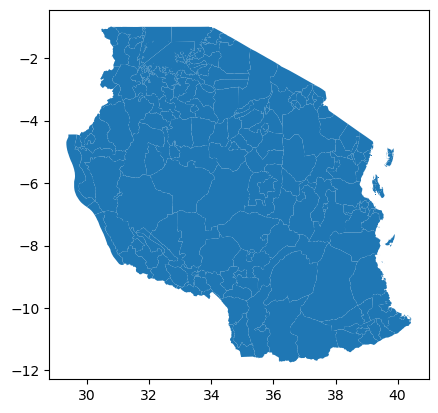

In [69]:
#load district shapefiles
shapefile = data_dir+'tz_shapefiles/tz_districts.shp'
district = gpd.read_file(shapefile)
district.plot()

#### Download The Data

In [21]:
#area=[min_lat,min_lon, max_lat, max_lon]
area = [-11.745695, 29.327168, -0.985788, 40.445137] 
directory_path = data_dir
variables = ['2m_temperature','total_precipitation']
output_filename = 'tz_combined_ERA5_data.nc'
month_range=(1,13)
year_range = (2005,2023)
#combine_annual_data(year_range, area, directory_path, variables,month_range,output_filename)

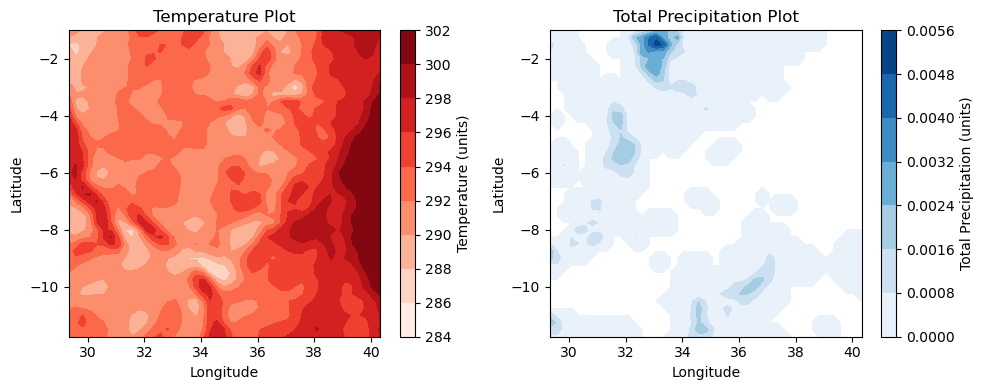

In [24]:
# sample of the NetCDF file
nc_file = data_dir+'ERA5_2010.nc'
plot_multiple_nc_variables(nc_file, [('t2m', 'Temperature'), ('tp', 'Total Precipitation')], time_index=0)

### Batch Processing of Data Extraction

In [31]:
# Load the NetCDF file containing meteorological data that you want to perform batch processing
nc_2016 = data_dir+'ERA5_2016.nc'
nc_2017 = data_dir+'ERA5_2017.nc'
nc_2018 = data_dir+'ERA5_2018.nc'
#nc_2021 = data_dir+'ERA5_2021.nc'
nc_files = [nc_2016,nc_2017,nc_2018]
output_directory = data_dir+ 'processed_data/'
#batch_data_extraction(nc_files, shapefile, output_directory)

### Visualizing the Data

In [32]:
data = read_csv(data_dir+ 'processed_data/2010_2011_meteo.csv')
data.head()

,year,month,region,district,t2m_mean,t2m_min,t2m_max,tp_sum,tp_min,tp_max
0,2010,1,Arusha,Arusha,294.82240,285.43814,305.75700,0.787141,0.0,0.008165
1,2010,1,Arusha,Arusha Urban,294.07693,285.43814,304.69000,0.503319,0.0,0.008165
2,2010,1,Arusha,Karatu,295.00922,284.93045,306.49850,3.963284,0.0,0.039808
3,2010,1,Arusha,Lake Eyasi,295.50818,286.17856,304.95508,1.581780,0.0,0.029535
4,2010,1,Arusha,Lake Manyara,296.43616,289.58972,306.49850,0.184640,0.0,0.004843


In [33]:
display_names = {'t2m_mean': 'Temperature Maximum', 'tp_sum': 'Total Rainfall'}
#plot_weather_trends(data, ['t2m_mean', 'tp_sum'], 'district', 'Magharibi',[2010,2011],display_names, save_path='tanzania_data/graphs/.png')

### Final Processing of The Data For Time Series

#### Splitting the data

In [74]:
#Load the datafiles

df1 = read_csv(data_dir+ 'processed_data/2010_2011_meteo.csv')
df2 = read_csv(data_dir+ 'processed_data/2012_2013_meteo.csv')
df3 = read_csv(data_dir+ 'processed_data/2014_2015_meteo.csv')
df4 = read_csv(data_dir+ 'processed_data/2019_2020_meteo.csv')
df5 = read_csv(data_dir+ 'processed_data/2020_2022_meteo.csv')
df6 = read_csv(data_dir+ 'processed_data/2023_2023_meteo.csv')
df7 = read_csv(data_dir+ 'processed_data/2016_2018_meteo.csv')

#Define Parameters and Call the function to split the data
data = [df1, df2, df3, df4, df5, df6,df7]

output_dir = data_dir + 'final_data/'

variable_to_filename = {
    't2m_mean': 't2m_mean_data.csv',
    't2m_min': 't2m_min_data.csv',
    't2m_max': 't2m_max_data.csv',
    'tp_sum': 'tp_sum_data.csv',
    'tp_min': 'tp_min_data.csv',
    'tp_max': 'tp_max_data.csv'
}
#process_multiple_dataframes(data,output_dir,variable_to_filename)

#### Transforming the data

In [75]:
'''
# Transform Rainfall Data
output_dir = data_dir+ 'final_data/rainfall_data'
df1 = read_csv(data_dir+ 'final_data/2010_2011_tp_sum_data.csv')
df2 = read_csv(data_dir+ 'final_data/2012_2013_tp_sum_data.csv')
df3 = read_csv(data_dir+ 'final_data/2014_2015_tp_sum_data.csv')
df4 = read_csv(data_dir+ 'final_data/2019_2020_tp_sum_data.csv')
df5 = read_csv(data_dir+ 'final_data/2020_2022_tp_sum_data.csv')
df6 = read_csv(data_dir+ 'final_data/2023_2023_tp_sum_data.csv')
df7 = read_csv(data_dir+ 'final_data/2016_2018_tp_sum_data.csv')
dataframes_info = [
    (df1, 'tp_sum'),
    (df2, 'tp_sum'),
    (df3, 'tp_sum'),
    (df4, 'tp_sum'),
    (df5, 'tp_sum'),
    (df6, 'tp_sum'),
    (df7, 'tp_sum')
]


batch_transform_and_save(dataframes_info,output_dir)


################################################################################################################
# Transform Maximum Temperature  Data
output_dir = data_dir+ 'final_data/tmax_data'
df1 = read_csv(data_dir+ 'final_data/2010_2011_t2m_max_data.csv')
df2 = read_csv(data_dir+ 'final_data/2012_2013_t2m_max_data.csv')
df3 = read_csv(data_dir+ 'final_data/2014_2015_t2m_max_data.csv')
df4 = read_csv(data_dir+ 'final_data/2019_2020_t2m_max_data.csv')
df5 = read_csv(data_dir+ 'final_data/2020_2022_t2m_max_data.csv')
df6 = read_csv(data_dir+ 'final_data/2023_2023_t2m_max_data.csv')
df7 = read_csv(data_dir+ 'final_data/2016_2018_t2m_max_data.csv')
dataframes_info = [
    (df1, 't2m_max'),
    (df2, 't2m_max'),
    (df3, 't2m_max'),
    (df4, 't2m_max'),
    (df5, 't2m_max'),
    (df6, 't2m_max'),
    (df7, 't2m_max'),
]
batch_transform_and_save(dataframes_info,output_dir)

##########################################################################################################################

# Transform Minimum Temperature  Data
output_dir = data_dir+ 'final_data/tmin_data'
df1 = read_csv(data_dir+ 'final_data/2010_2011_t2m_min_data.csv')
df2 = read_csv(data_dir+ 'final_data/2012_2013_t2m_min_data.csv')
df3 = read_csv(data_dir+ 'final_data/2014_2015_t2m_min_data.csv')
df4 = read_csv(data_dir+ 'final_data/2019_2020_t2m_min_data.csv')
df5 = read_csv(data_dir+ 'final_data/2020_2022_t2m_min_data.csv')
df6 = read_csv(data_dir+ 'final_data/2023_2023_t2m_min_data.csv')
df7 = read_csv(data_dir+ 'final_data/2016_2018_t2m_min_data.csv')

dataframes_info = [
    (df1, 't2m_min'),
    (df2, 't2m_min'),
    (df3, 't2m_min'),
    (df4, 't2m_min'),
    (df5, 't2m_min'),
    (df6, 't2m_min'),
    (df7, 't2m_min')
]
batch_transform_and_save(dataframes_info,output_dir)
'''

Transformed data saved to tanzania_data/meteorological_data/final_data/rainfall_data/2010_2011_data_rainfall.csv
Transformed data saved to tanzania_data/meteorological_data/final_data/rainfall_data/2012_2013_data_rainfall.csv
Transformed data saved to tanzania_data/meteorological_data/final_data/rainfall_data/2014_2015_data_rainfall.csv
Transformed data saved to tanzania_data/meteorological_data/final_data/rainfall_data/2019_2020_data_rainfall.csv
Transformed data saved to tanzania_data/meteorological_data/final_data/rainfall_data/2020_2022_data_rainfall.csv
Transformed data saved to tanzania_data/meteorological_data/final_data/rainfall_data/2023_2023_data_rainfall.csv
Transformed data saved to tanzania_data/meteorological_data/final_data/rainfall_data/2016_2018_data_rainfall.csv


"\n################################################################################################################\n# Transform Maximum Temperature  Data\noutput_dir = data_dir+ 'final_data/tmax_data'\ndf1 = read_csv(data_dir+ 'final_data/2010_2011_t2m_max_data.csv')\ndf2 = read_csv(data_dir+ 'final_data/2012_2013_t2m_max_data.csv')\ndf3 = read_csv(data_dir+ 'final_data/2014_2015_t2m_max_data.csv')\ndf4 = read_csv(data_dir+ 'final_data/2019_2020_t2m_max_data.csv')\ndf5 = read_csv(data_dir+ 'final_data/2020_2022_t2m_max_data.csv')\ndf6 = read_csv(data_dir+ 'final_data/2023_2023_t2m_max_data.csv')\ndf7 = read_csv(data_dir+ 'final_data/2016_2018_t2m_max_data.csv')\ndataframes_info = [\n    (df1, 't2m_max'),\n    (df2, 't2m_max'),\n    (df3, 't2m_max'),\n    (df4, 't2m_max'),\n    (df5, 't2m_max'),\n    (df6, 't2m_max'),\n    (df7, 't2m_max'),\n]\nbatch_transform_and_save(dataframes_info,output_dir)\n\n#######################################################################################

In [79]:
data_dir = 'tanzania_data/meteorological_data/final_data/rainfall_data/'
input_file = data_dir + 'tz_rainfall_data.csv'
output_file = data_dir + 'data_rainfall.xlsx'
process_rainfall_data(input_file, output_file)

Processed data saved to: tanzania_data/meteorological_data/final_data/rainfall_data/data_rainfall.xlsx


### Visualizing The Data

In [6]:
rainfall_data = read_csv(data_dir + 'final_data/rainfall_data/tz_rainfall_data.csv')
rainfall_data.tail()

,year,region,district,rainfall01,rainfall02,rainfall03,rainfall04,rainfall05,rainfall06,rainfall07,rainfall08,rainfall09,rainfall10,rainfall11,rainfall12
2585,2023,Tanga,Lushoto,357.312620,224.412740,799.74120,3045.9635,626.56840,443.8963,272.26037,349.16080,330.05545,776.30150,3203.4562,1609.92170
2586,2023,Tanga,Mkinga,321.934550,132.161240,662.72813,3648.5348,836.12170,586.9833,514.61154,527.27354,496.33175,876.24100,3260.1042,1279.82250
2587,2023,Tanga,Muheza,193.053830,106.639445,482.36394,2469.4295,661.51255,533.5720,411.25473,453.17286,378.19225,704.03993,2289.8123,761.98100
2588,2023,Tanga,Pangani,250.741200,120.484930,635.78180,3181.5321,832.16370,576.5552,442.67190,514.11860,415.80898,1172.47350,2784.7393,701.17366
2589,2023,Tanga,Tanga,107.626334,47.489960,257.31677,1464.9853,399.67710,289.5842,244.53919,249.48731,218.42876,357.48690,1337.0084,372.26072


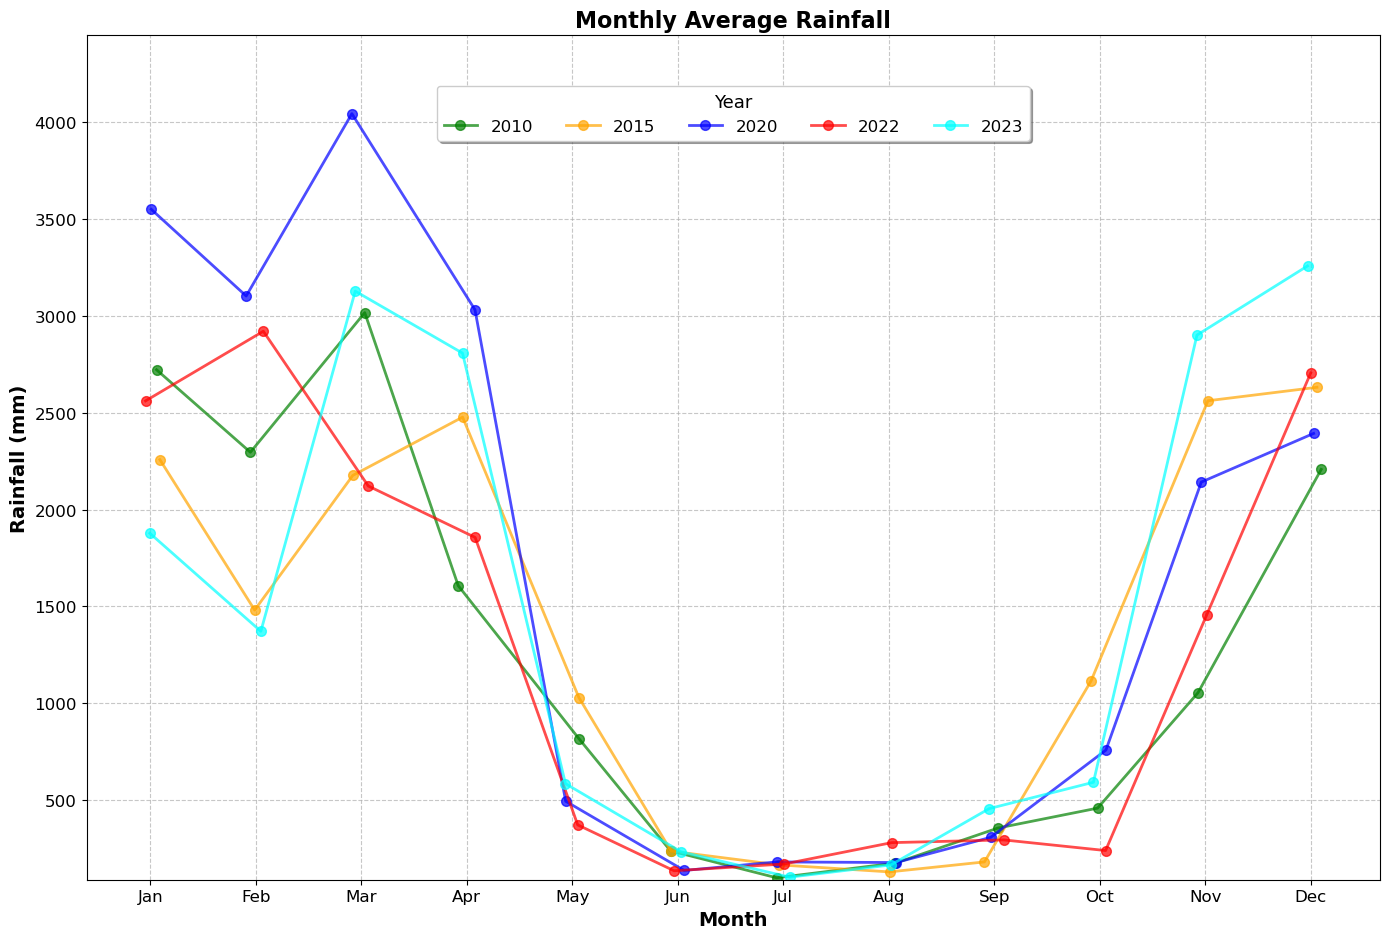

In [44]:
save_path='timeseries_graph/tz_rainfall_trends4.png'
plot_rainfall_trends_4(rainfall_data, [2010,2015,2020,2022,2023], save_path)

In [68]:
tmax_data = read_csv(data_dir + 'final_data/tmax_data/tz_tmax_data.csv')
tmax_data.tail()
tmin_data = read_csv(data_dir + 'final_data/tmin_data/tz_tmin_data.csv')
tmin_data.tail()

,year,region,district,tmin01,tmin02,tmin03,tmin04,tmin05,tmin06,tmin07,tmin08,tmin09,tmin10,tmin11,tmin12
2585,2023,Tanga,Lushoto,17.00057,17.75750,17.81924,16.95944,16.49420,13.67800,12.93374,12.71218,14.31204,14.69128,17.69420,17.89202
2586,2023,Tanga,Mkinga,18.89843,18.93905,18.94540,19.28720,18.68008,16.19882,14.81472,15.14650,16.46414,16.74212,19.37370,20.12905
2587,2023,Tanga,Muheza,19.69756,19.52615,19.53933,19.33837,19.02664,16.19882,14.81472,15.70773,17.35293,17.16040,19.95657,20.57635
2588,2023,Tanga,Pangani,22.08810,22.21417,22.31070,21.76846,21.06320,19.00604,17.35928,18.81774,19.56940,19.65800,21.83490,22.76537
2589,2023,Tanga,Tanga,21.98680,21.61495,21.62075,21.66454,20.76992,19.00604,17.00323,18.33880,19.56940,19.32833,21.72677,22.39984


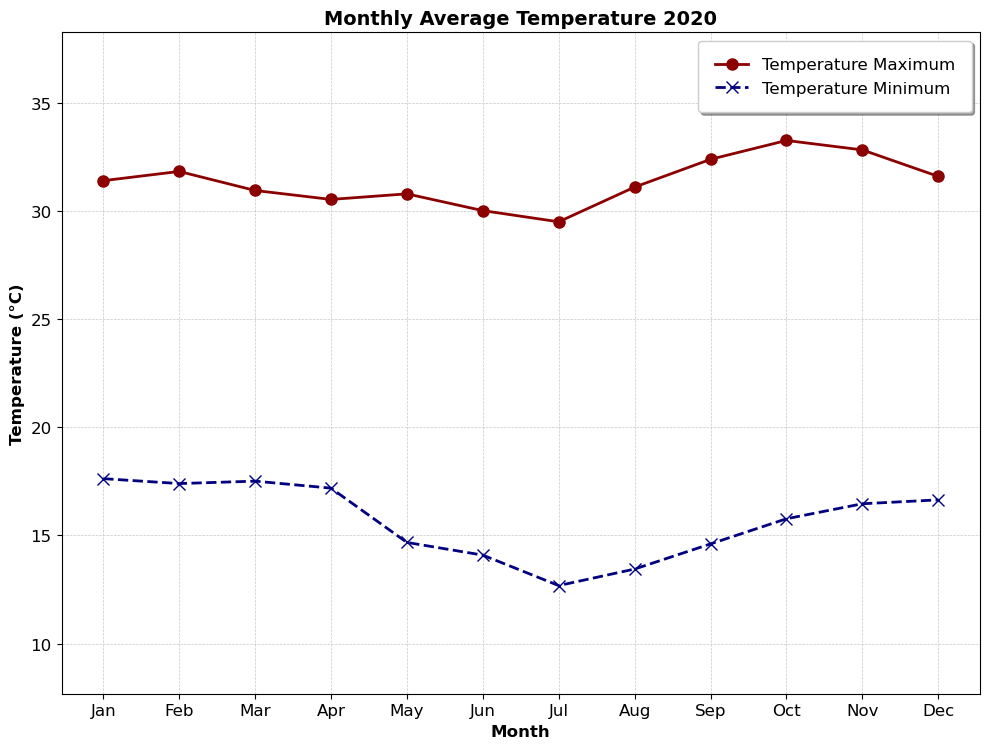

In [69]:
save_path='timeseries_graph/tz_temperature_trends.png'
#years_list = [(2010, 2011), (2012, 2013), (2014, 2015),(2019,2020),(2020,2021),(2022,2023)]
#prepare_and_plot_temp_data(tmax_data, tmin_data,years_list, save_path)
prepare_and_plot_temp_data_single_year(tmax_data, tmin_data,2020, save_path)

## Download and Extra Meteorological Data For Rwanda

In [80]:
#define a data directory
data_dir_rw = 'rwanda_data/meteorological_data/'

In [51]:
#Getting the bounding box of Rwanda
data = compute_country_bounds(data_dir_rw+'rw_shapefiles/rw_country.shp')
data.head()

,country,min_lat,min_lon,max_lat,max_lon
0,Rwanda,-2.839973,28.861708,-1.04745,30.899073


#### Download The Data

In [79]:
#area=[min_lat,min_lon, max_lat, max_lon]
area = [-2.839973, 28.861708, -1.04745, 30.899073] 
directory_path = data_dir_rw
variables = ['2m_temperature','total_precipitation']
output_filename = 'rw_combined_ERA5_data.nc'
month_range=(1,13)
year_range = (2005,2023)
#combine_annual_data(year_range, area, directory_path, variables,month_range,output_filename)

#### Extra The Data For Each District

<Axes: >

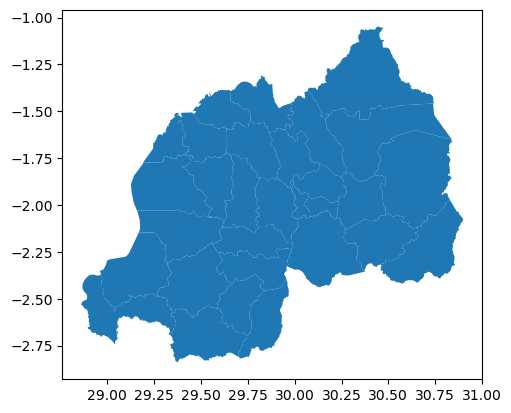

In [28]:
#load district shapefiles
rw_shapefile = data_dir_rw +'rw_shapefiles/rw_district.shp'
rw_district = gpd.read_file(rw_shapefile)
rw_district.plot()

In [81]:
nc_file = data_dir_rw+'ERA5_2010.nc'

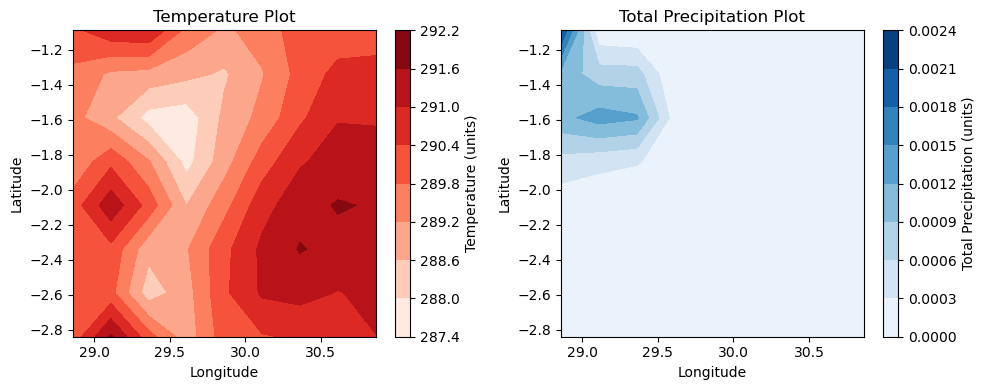

In [82]:
plot_multiple_nc_variables(nc_file, [('t2m', 'Temperature'), ('tp', 'Total Precipitation')], time_index=0)

### Batch Processing of Data Extraction

In [32]:
# Load the NetCDF file containing meteorological data that you want to perform batch processing
nc_2005 = data_dir_rw+'ERA5_2005.nc'
nc_2006 = data_dir_rw+'ERA5_2006.nc'
nc_2011 = data_dir_rw+'ERA5_2011.nc'
nc_2012 = data_dir_rw+'ERA5_2012.nc'
nc_2014 = data_dir_rw+'ERA5_2014.nc'
nc_2015 = data_dir_rw+'ERA5_2015.nc'
nc_2017 = data_dir_rw+'ERA5_2017.nc'
nc_2018 = data_dir_rw+'ERA5_2018.nc'
nc_2020 = data_dir_rw+'ERA5_2020.nc'
nc_2021 = data_dir_rw+'ERA5_2021.nc'
nc_files = [nc_2005, nc_2006, nc_2011,  nc_2012, nc_2014, nc_2015, nc_2017, nc_2018, nc_2020, nc_2021]
output_directory = data_dir_rw + 'processed_data/'
#batch_data_extraction(nc_files, rw_shapefile, output_directory)
#data_extract=extract_weather_data(nc_2005, rw_shapefile)
data_extract.head()

,longitude,latitude,time,spatial_ref,t2m,tp,province,district
0,29.611376,-1.339,2005-01-01 00:00:00,0,287.604309,0.0,Amajyaruguru,Burera
1,29.611376,-1.339,2005-01-01 01:00:00,0,287.642853,0.0,Amajyaruguru,Burera
2,29.611376,-1.339,2005-01-01 02:00:00,0,287.621368,0.0,Amajyaruguru,Burera
3,29.611376,-1.339,2005-01-01 03:00:00,0,287.716644,0.0,Amajyaruguru,Burera
4,29.611376,-1.339,2005-01-01 04:00:00,0,287.600281,0.0,Amajyaruguru,Burera


In [36]:
data_extract.head(20)

,longitude,latitude,time,spatial_ref,t2m,tp,province,district
0,29.611376,-1.339,2005-01-01 00:00:00,0,287.604309,0.000000e+00,Amajyaruguru,Burera
1,29.611376,-1.339,2005-01-01 01:00:00,0,287.642853,0.000000e+00,Amajyaruguru,Burera
2,29.611376,-1.339,2005-01-01 02:00:00,0,287.621368,0.000000e+00,Amajyaruguru,Burera
3,29.611376,-1.339,2005-01-01 03:00:00,0,287.716644,0.000000e+00,Amajyaruguru,Burera
4,29.611376,-1.339,2005-01-01 04:00:00,0,287.600281,0.000000e+00,Amajyaruguru,Burera
5,29.611376,-1.339,2005-01-01 05:00:00,0,288.056885,0.000000e+00,Amajyaruguru,Burera
6,29.611376,-1.339,2005-01-01 06:00:00,0,290.107971,0.000000e+00,Amajyaruguru,Burera
7,29.611376,-1.339,2005-01-01 07:00:00,0,291.719086,5.851313e-05,Amajyaruguru,Burera
8,29.611376,-1.339,2005-01-01 08:00:00,0,292.330200,1.424439e-04,Amajyaruguru,Burera
9,29.611376,-1.339,2005-01-01 09:00:00,0,294.911743,9.811483e-05,Amajyaruguru,Burera


In [33]:
df_obt = compute_district_monthly_stats(data_extract)

In [34]:
df_obt.head(10)

,year,month,province,district,t2m_mean,t2m_min,t2m_max,tp_sum,tp_min,tp_max
0,2005,1,Amajyaruguru,Burera,291.418671,283.291656,300.526917,0.753166,0.0,0.007995
1,2005,1,Amajyaruguru,Gakenke,290.888489,282.799774,299.764557,0.688766,0.0,0.007995
2,2005,1,Amajyaruguru,Gicumbi,292.898804,284.966858,302.491241,0.597162,0.0,0.006178
3,2005,1,Amajyaruguru,Musanze,290.698395,283.227173,299.447845,0.755428,0.0,0.007995
4,2005,1,Amajyaruguru,Rulindo,292.392639,284.468048,300.653442,0.396354,0.0,0.006178
5,2005,1,Amajyepfo,Gisagara,293.314484,284.946167,301.992859,0.354235,0.0,0.004749
6,2005,1,Amajyepfo,Huye,293.122284,284.990356,301.992859,0.340402,0.0,0.004457
7,2005,1,Amajyepfo,Kamonyi,293.233124,284.468048,301.602356,0.326464,0.0,0.004403
8,2005,1,Amajyepfo,Muhanga,291.865204,282.799774,301.112061,0.560309,0.0,0.006738
9,2005,1,Amajyepfo,Nyamagabe,291.542145,284.257996,300.536255,0.901129,0.0,0.006390


#### Visualizing the data

In [84]:
data = read_csv(data_dir_rw+ 'processed_data/2006_2021_meteo.csv')
data.head()

,year,month,province,district,t2m_mean,t2m_min,t2m_max,tp_sum,tp_min,tp_max
0,2006,1,Amajyaruguru,Burera,291.05383,282.69280,301.72900,1.013598,0.0,0.008743
1,2006,1,Amajyaruguru,Gakenke,290.52762,282.65160,301.35608,0.801369,0.0,0.008743
2,2006,1,Amajyaruguru,Gicumbi,292.57547,284.06442,303.71362,0.739172,0.0,0.008743
3,2006,1,Amajyaruguru,Musanze,290.29657,282.69280,299.74118,1.204756,0.0,0.009546
4,2006,1,Amajyaruguru,Rulindo,292.04285,283.98240,302.15270,0.451304,0.0,0.008743


In [88]:
display_names = {'t2m_mean': 'Average Temperature', 'tp_sum': 'Total Rainfall'}
#plot_weather_trends(data, ['t2m_mean', 'tp_sum'], 'district', 'Burera',[2006,2012,2015],display_names, save_path='rwanda_data/graphs/.png')

### Final Processing of The Data For Time Series

#### Splitting the Data

In [50]:
#Load the datafiles
df1 = read_csv(data_dir_rw+ 'processed_data/meteo_2006.csv')
df2 = read_csv(data_dir_rw+ 'processed_data/meteo_2012.csv')
df3 = read_csv(data_dir_rw+ 'processed_data/meteo_2015.csv')
df4 = read_csv(data_dir_rw+ 'processed_data/meteo_2018.csv')
df5 = read_csv(data_dir_rw+ 'processed_data/meteo_2021.csv')
df6 = read_csv(data_dir_rw+ 'processed_data/2005_2021_meteo.csv')
#Define Parameters and Call the function to split the data
data = [df1, df2, df3, df4, df5, df6]
output_dir = data_dir_rw + 'final_data/'

variable_to_filename = {
    't2m_mean': 't2m_mean_data.csv',
    't2m_min': 't2m_min_data.csv',
    't2m_max': 't2m_max_data.csv',
    'tp_sum': 'tp_sum_data.csv',
    'tp_min': 'tp_min_data.csv',
    'tp_max': 'tp_max_data.csv'
}
#process_multiple_dataframes(data,output_dir,variable_to_filename)

#### Transforming the data

In [81]:
'''
# Transform Rainfall Data
output_dir = data_dir_rw+ 'final_data/rainfall_data'
df1 = read_csv(data_dir_rw+ 'final_data/2006_2006_tp_sum_data.csv')
df2 = read_csv(data_dir_rw+ 'final_data/2012_2012_tp_sum_data.csv')
df3 = read_csv(data_dir_rw+ 'final_data/2015_2015_tp_sum_data.csv')
df4 = read_csv(data_dir_rw+ 'final_data/2018_2018_tp_sum_data.csv')
df5 = read_csv(data_dir_rw+ 'final_data/2021_2021_tp_sum_data.csv')
df6 = read_csv(data_dir_rw+ 'final_data/2005_2021_tp_sum_data.csv')
dataframes_info = [
    (df1, 'tp_sum'),
    (df2, 'tp_sum'),
    (df3, 'tp_sum'),
    (df4, 'tp_sum'),
    (df5, 'tp_sum'),
    (df6, 'tp_sum'),
]
batch_transform_and_save(dataframes_info,output_dir)

##################################################################################################

# Transform Maximum Temperature Data
output_dir = data_dir_rw+ 'final_data/tmax_data'
df1 = read_csv(data_dir_rw+ 'final_data/2006_2006_t2m_max_data.csv')
df2 = read_csv(data_dir_rw+ 'final_data/2012_2012_t2m_max_data.csv')
df3 = read_csv(data_dir_rw+ 'final_data/2015_2015_t2m_max_data.csv')
df4 = read_csv(data_dir_rw+ 'final_data/2018_2018_t2m_max_data.csv')
df5 = read_csv(data_dir_rw+ 'final_data/2021_2021_t2m_max_data.csv')
df6 = read_csv(data_dir_rw+ 'final_data/2005_2021_t2m_max_data.csv')
dataframes_info = [
    (df1, 't2m_max'),
    (df2, 't2m_max'),
    (df3, 't2m_max'),
    (df4, 't2m_max'),
    (df5, 't2m_max'),
    (df6, 't2m_max')
]
batch_transform_and_save(dataframes_info,output_dir)

######################################################################################################

# Transform Minimum Temperature Data
output_dir = data_dir_rw+ 'final_data/tmin_data'
df1 = read_csv(data_dir_rw+ 'final_data/2006_2006_t2m_min_data.csv')
df2 = read_csv(data_dir_rw+ 'final_data/2012_2012_t2m_min_data.csv')
df3 = read_csv(data_dir_rw+ 'final_data/2015_2015_t2m_min_data.csv')
df4 = read_csv(data_dir_rw+ 'final_data/2018_2018_t2m_min_data.csv')
df5 = read_csv(data_dir_rw+ 'final_data/2021_2021_t2m_min_data.csv')
df6 = read_csv(data_dir_rw+ 'final_data/2005_2021_t2m_min_data.csv')

dataframes_info = [
    (df1, 't2m_min'),
    (df2, 't2m_min'),
    (df3, 't2m_min'),
    (df4, 't2m_min'),
    (df5, 't2m_min'),
    (df6, 't2m_min')
]
batch_transform_and_save(dataframes_info,output_dir)
'''

Transformed data saved to rwanda_data/meteorological_data/final_data/rainfall_data/2006_2006_data_rainfall.csv
Transformed data saved to rwanda_data/meteorological_data/final_data/rainfall_data/2012_2012_data_rainfall.csv
Transformed data saved to rwanda_data/meteorological_data/final_data/rainfall_data/2015_2015_data_rainfall.csv
Transformed data saved to rwanda_data/meteorological_data/final_data/rainfall_data/2018_2018_data_rainfall.csv
Transformed data saved to rwanda_data/meteorological_data/final_data/rainfall_data/2021_2021_data_rainfall.csv
Transformed data saved to rwanda_data/meteorological_data/final_data/rainfall_data/2005_2021_data_rainfall.csv


"\n##################################################################################################\n\n# Transform Maximum Temperature Data\noutput_dir = data_dir_rw+ 'final_data/tmax_data'\ndf1 = read_csv(data_dir_rw+ 'final_data/2006_2006_t2m_max_data.csv')\ndf2 = read_csv(data_dir_rw+ 'final_data/2012_2012_t2m_max_data.csv')\ndf3 = read_csv(data_dir_rw+ 'final_data/2015_2015_t2m_max_data.csv')\ndf4 = read_csv(data_dir_rw+ 'final_data/2018_2018_t2m_max_data.csv')\ndf5 = read_csv(data_dir_rw+ 'final_data/2021_2021_t2m_max_data.csv')\ndf6 = read_csv(data_dir_rw+ 'final_data/2005_2021_t2m_max_data.csv')\ndataframes_info = [\n    (df1, 't2m_max'),\n    (df2, 't2m_max'),\n    (df3, 't2m_max'),\n    (df4, 't2m_max'),\n    (df5, 't2m_max'),\n    (df6, 't2m_max')\n]\nbatch_transform_and_save(dataframes_info,output_dir)\n\n######################################################################################################\n\n# Transform Minimum Temperature Data\noutput_dir = data_dir_rw+ 

## Visualizing The Data

In [56]:
rainfall_data = read_csv(data_dir_rw + 'final_data/rainfall_data/2005_2021_data_rainfall.csv')
rainfall_data.head()

,year,province,district,rainfall01,rainfall02,rainfall03,rainfall04,rainfall05,rainfall06,rainfall07,rainfall08,rainfall09,rainfall10,rainfall11,rainfall12
0,2005,Amajyaruguru,Burera,753.16600,579.59620,1503.7577,1091.0908,1383.9176,221.74144,62.181592,880.42870,921.66203,1383.7545,925.98650,559.65906
1,2005,Amajyaruguru,Gakenke,688.76590,483.67864,1056.3116,788.8706,930.2709,145.97180,29.740082,584.07940,556.37175,1003.4384,629.18496,453.34620
2,2005,Amajyaruguru,Gicumbi,597.16225,521.85970,1283.2273,1018.2490,1180.0666,170.29740,23.733238,613.74444,593.95970,1085.1420,799.37565,420.92827
3,2005,Amajyaruguru,Musanze,755.42754,614.29290,1618.8325,1230.4130,1673.1486,449.76205,113.979640,1095.66780,1482.22050,2195.4710,1418.48520,751.24200
4,2005,Amajyaruguru,Rulindo,396.35440,328.91860,738.0331,549.2033,651.8413,79.81373,8.662827,322.86130,279.58414,627.2078,454.99516,249.20548


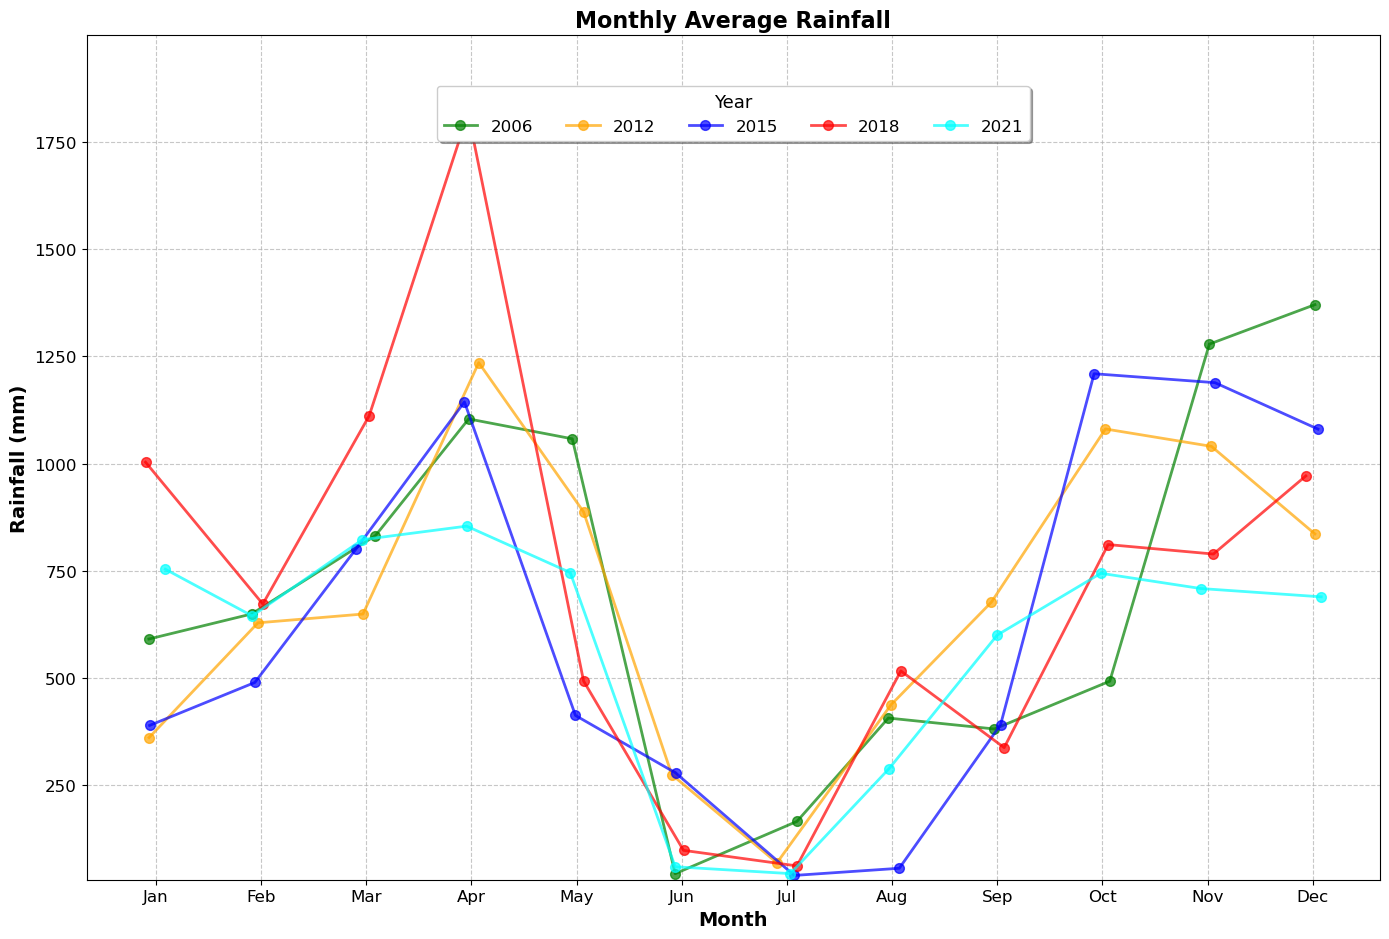

In [47]:
save_path='timeseries_graph/rw_rainfall_trends4.png'
#plot_rainfall_trends(rainfall_data, [2006, 2012, 2015, 2018, 2021], save_path)
plot_rainfall_trends_4(rainfall_data, [2006,2012,2015,2018,2021], save_path)

In [22]:
tmax_data = read_csv(data_dir_rw + 'final_data/tmax_data/2005_2021_data_tmax.csv')
tmax_data.tail()
tmin_data = read_csv(data_dir_rw + 'final_data/tmin_data/2005_2021_data_tmin.csv')
tmin_data.tail()

,year,province,district,tmin01,tmin02,tmin03,tmin04,tmin05,tmin06,tmin07,tmin08,tmin09,tmin10,tmin11,tmin12
295,2021,Iburengerazuba,Rusizi,12.48834,11.85378,11.28164,12.30505,12.39633,11.11697,10.62628,11.30975,12.50660,12.10424,12.51754,12.27767
296,2021,Iburengerazuba,Rutsiro,10.92455,11.20315,10.28230,11.96478,12.45840,10.36923,11.22580,11.31814,12.05203,11.21118,10.41888,11.81326
297,2021,Umujyi wa Kigali,Gasabo,14.13537,14.31793,14.53808,14.20364,15.00945,13.58114,14.50960,14.36395,14.60308,14.42820,14.18575,14.60818
298,2021,Umujyi wa Kigali,Kicukiro,14.13537,14.31793,14.53808,14.20364,15.00945,13.58114,14.50960,14.36395,14.60308,14.42820,14.18575,14.60818
299,2021,Umujyi wa Kigali,Nyarugenge,12.23568,12.21890,12.58035,12.71838,13.69250,12.00200,13.29852,12.66213,13.27917,12.81548,12.40655,12.80710


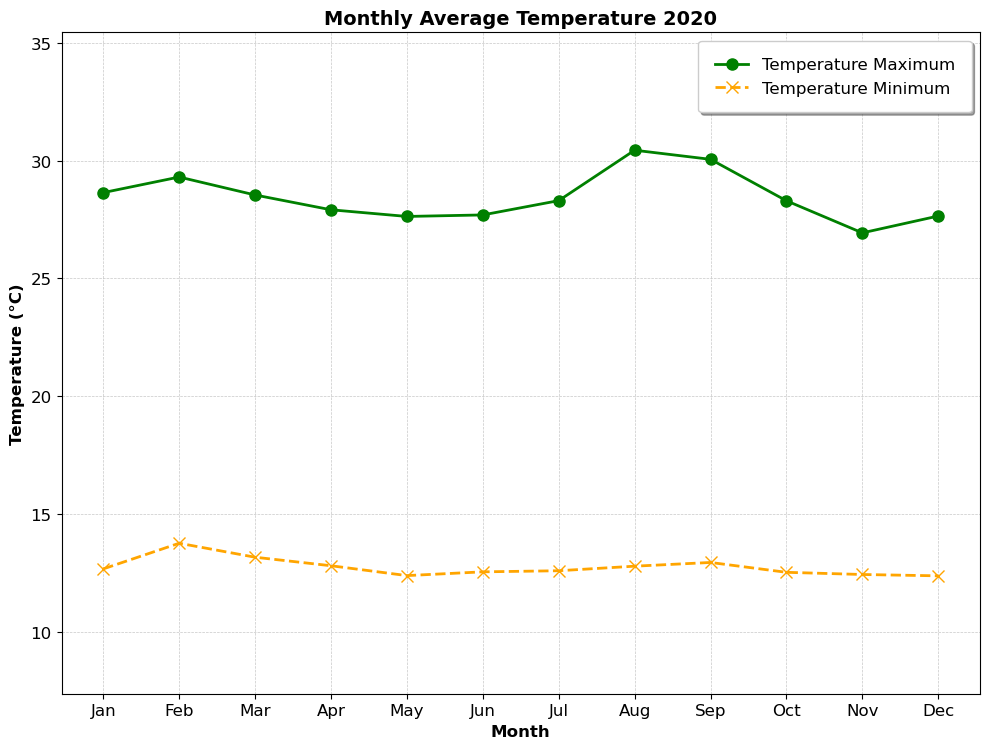

In [23]:
save_path='timeseries_graph/rw_temperature_trends.png'
#years_list = [2006, 2012, 2015, 2018, 2021]
#prepare_and_plot_temp_data(tmax_data, tmin_data,years_list, save_path)
prepare_and_plot_temp_data_single_year(tmax_data, tmin_data,2020, save_path)